In [ ]:
# first mount your gdrive
from google.colab import drive
drive.mount('/content/drive/')

# next, add the location of the file to the path:
import sys
sys.path.append('/content/drive/My Drive/Stage/code_test_nicolas')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from fonction_compteur_background import filtre_morpho

from scipy import ndimage as ndi

from skimage.measure    import regionprops
from skimage.morphology import watershed, label, black_tophat, disk
from skimage.io         import imsave
import pandas as pd



In [ ]:
# fonction qui permet de transformer l'image en noir et blanc (utilisée pour la génération des labels )
def preprocessing(original_image):
    image_gray=original_image
    binary_image = cv2.threshold(image_gray,1,255, cv2.THRESH_BINARY)
    return binary_image


In [ ]:
#fonction pour sauvegrder les imagettes extraites dans un fichier
def sauvegarde_imagette(image,zoro, classe,coords_para=False,coords_distrac=False, cells_mean=60, size1=74,size2=71, 
                        travel_output=os.getcwd()+"_output/", tophat=False):
    """
    sauvegarde_imagette : save segmente cells with label if we have coordonate of parasite.
    image           : input image
    classe          : list of region segmented
    coords_para     : tuple or array with coordonate of all parasite.
    size1           : heigth of small picture
    size2           : width small picture
    travel_output   : folder output dataset
    """
    debut=time.time()
    print("nombre de régions détectées:", np.shape(classe))
    c=0
    #
#    test debug
    list_label=[]
    #existence of folder
    if not os.path.exists(travel_output):
       os.mkdir(travel_output)
       
    #existence of folder tophat
    if tophat:
        travel_tophat=travel_output[:-1]+'_tophat/'
        if not os.path.exists(travel_tophat):
           os.mkdir(travel_tophat)
       
    #tranforme coords_para
    if type(coords_para)==np.ndarray:
        list_para=list(coords_para)
    elif coords_para is False:
        pass
    else:
        if 2 in coords_para.shape and len(coords_para.shape)==2:
            if coords_para.shape[0]==2:
                coords_para=coords_para.T
                list_para=list(coords_para)
        else:
            print("coords_para n'est pas à la bonne taille\ncoords_para shape=",coords_para.shape)
            return None
    if coords_distrac is False:
        pass
    else:
        list_distrac=list(coords_distrac)
    
    #tophat image
    if tophat:
        
        black_para=black_tophat(zoro, selem=disk(5))
        black_para[black_para.mask]=0
    
    for region in classe:
        infected=False
        distrac =False
        taille=image[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]].shape
        
        dx0 = region.bbox[0]
        dx1 = region.bbox[2]
        dy0 = region.bbox[1]
        dy1 = region.bbox[3]

        if(taille[0]%2!=0):
          dx1=dx1+1
        if(taille[1]%2!=0):
          dy1=dy1+1

        taille=image[dx0:dx1,dy0:dy1].shape

        if taille[0]>size1 or taille[1]>size2:
            c=c+1
            
            #print('problème de taille')
        else:
            image_sortie=np.zeros([size1,size2], dtype='uint8')
            if tophat:
                image_tophat=np.zeros_like(image_sortie)
            if region.equivalent_diameter>cells_mean*9/16:
                
                xc,yc=region.centroid
                x=int(xc-region.bbox[0])
                y=int(yc-region.bbox[1])
                center1=int(size1/2)
                center2=int(size2/2)
                begin_x=center1-x
                begin_y=center2-y
                coords = region.coords
                #test de depassement
                if np.max(coords[:,0]-region.bbox[0]+begin_x)>size1-1:
                    recalage_x=np.max(coords[:,0]-region.bbox[0]+begin_x)-size1+1
                    begin_x=begin_x-recalage_x
                if np.max(coords[:,1]-region.bbox[1]+begin_y)>size2-1:
                    recalage_y=np.max(coords[:,1]-region.bbox[1]+begin_y)-size2+1
                    begin_y=begin_y-recalage_y
                    
                #imagette image
                #image_sortie[coords[:,0]-region.bbox[0]+begin_x, coords[:,1]-region.bbox[1]+begin_y]=\
                #image[coords[:,0],coords[:,1]]

                diffx1 = diffx2 = int((size1 - taille[0] )/2)
                diffy1 = diffy2 = int((size2 - taille[1] )/2)

                maxx,maxy = image.shape

                print(image.shape)

                print(dx0-diffx1,dx1+diffx2,dy0-diffy1,dy1+diffy2)
                
                print(maxx,maxy)
                if(dx0-diffx1<0):
                  diffx2 = diffx2 + (dx0-diffx1)*(-1)
                  diffx1 = diffx1 - (dx0-diffx1)*(-1)
                if(dx1+diffx2 > maxx):
                  diffx1 = diffx1 + (maxx- dx1-diffx2)*(-1)
                  diffx2 = diffx2 - (maxx- dx1-diffx2)*(-1)
                if(dy0-diffy1<0):
                  diffy2 = diffy2 + (dy0-diffy1)*(-1)
                  diffy1 = diffy1 - (dy0-diffy1)*(-1)
                if(dy1+diffy2 > maxy):
                  diffy1 = diffy1 + (maxy- dy1-diffy2)*(-1)
                  diffy2 = diffy2 - (maxy- dy1-diffy2)*(-1)
                
                print(dx0-diffx1,dx1+diffx2,dy0-diffy1,dy1+diffy2)

                image_sortie[center1-int(size1/2):center1+int(size1/2), center2-int(size2/2):center2+int(size2/2)]=\
                image[dx0-diffx1:dx1+diffx2,dy0-diffy1:dy1+diffy2]
              
                plt.figure(figsize=(10,10))
                plt.subplot(1, 3, 3),plt.imshow(image_sortie, cmap='gray')
                plt.show()

                #imagette tophat
                if tophat:
                    image_tophat[coords[:,0]-region.bbox[0]+begin_x, coords[:,1]-region.bbox[1]+begin_y]=\
                black_para[coords[:,0],coords[:,1]]
                
                title='('+str(int(round(xc)))+','+str(int(round(yc)))+')'+'_'+str(region.label)+'.png'
                
                imsave(travel_output+title, image_sortie)
                list_label.append(region.label)
                if tophat:
                    imsave(travel_tophat+title, image_tophat, check_contrast=False)
    print("\n nbr de regions cluster", c)
    fin=time.time()
    
    print("\n t=",fin-debut)
    
    return None
                                       


In [ ]:
#lire l'image originale et l'image segmentée  prédite 
image=cv2.imread('/content/drive/My Drive/Stage/code_test_nicolas/data/CAT01/0.bmp')
zoro=cv2.imread('/content/drive/My Drive/Stage/code_test_nicolas/data/CAT01_Labeling/0.png')


In [ ]:
print(np.array(zoro).shape)

(2,)


In [ ]:
zoro= preprocessing(zoro)

In [ ]:
print(np.array(zoro).shape)

(2,)


In [ ]:
image= zoro[1][:,:,1]

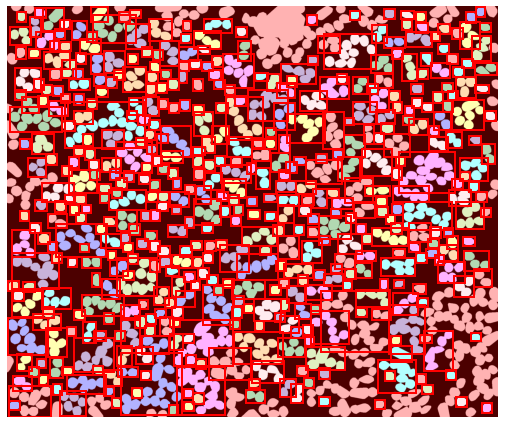

In [ ]:
#cette partie est pour l'extraction des regions  qui sert à séparer les cellules chacune dans une imagette
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb




# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))


# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        

ax.set_axis_off()
plt.tight_layout()


In [ ]:
classe=regionprops(label_image)

image=cv2.imread('/content/drive/My Drive/Stage/code_test_nicolas/data/CAT01/0.bmp')

In [ ]:
print(len(classe))

504


In [ ]:

np.shape(classe)

(504,)

In [ ]:
travel_dataset="/content/drive/My Drive/Stage/code_test_nicolas/data/new_test/"
travel_para=False


In [ ]:
#sauvegarder les imagettes extraites dans un dossier
sauvegarde_imagette(image[:,:,1],zoro, classe,coords_para=False,coords_distrac=False, cells_mean=60, size1=84,size2=84,travel_output=travel_dataset, tophat=False)

Output hidden; open in https://colab.research.google.com to view.